In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import os
import seaborn as sns

In [2]:
from functools import wraps
import psutil
import tracemalloc
import time

## Data Loading

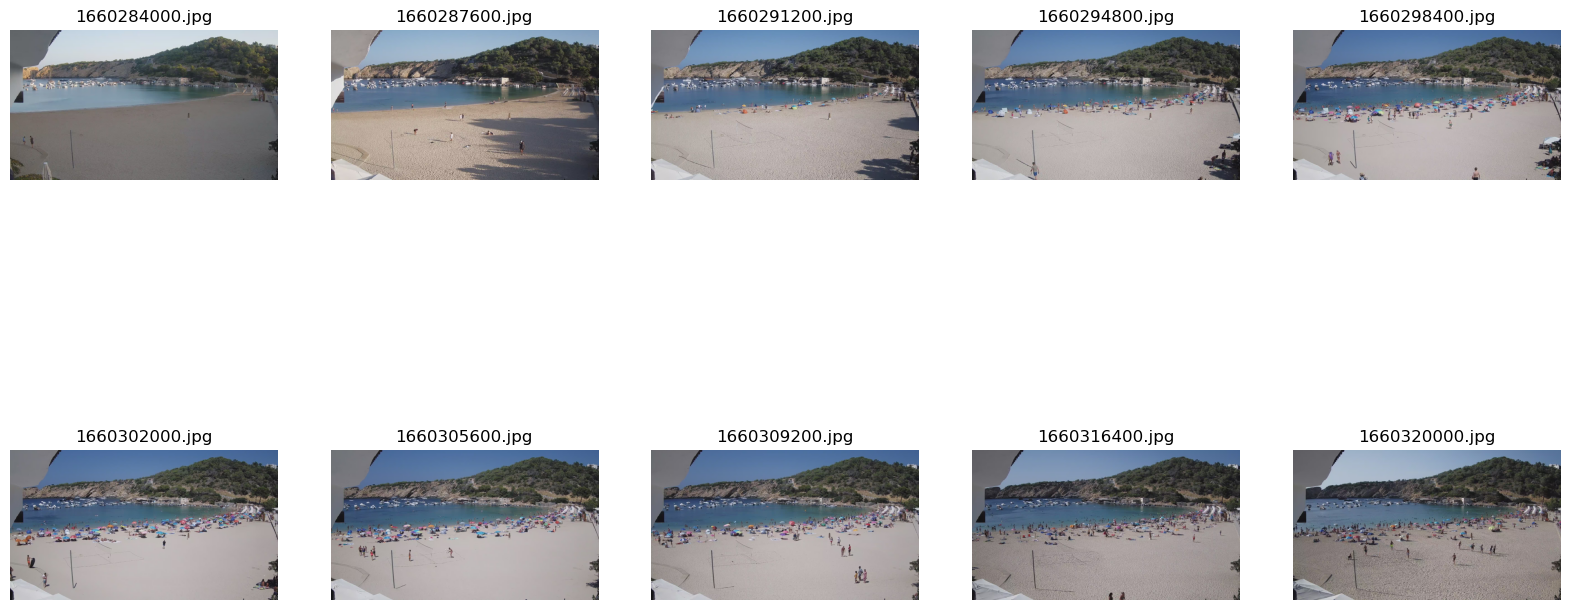

In [3]:
img_path = './data'
image_files = sorted([f for f in os.listdir(img_path) if f.endswith('.jpg')])
input_images = [cv2.imread(os.path.join(img_path, f)) for f in image_files]
image_names = image_files

fig, axes = plt.subplots(2, len(input_images) // 2, figsize=(20, 10))
for ax, img, name in zip(axes.flatten(), input_images, image_names):
    ax.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    ax.set_title(name)
    ax.axis('off')
plt.show()

In [4]:
annotations = pd.read_csv('./data/manual_annotations.csv')
annotations.head()

label  point_x  point_y      image_name  image_width  image_height
0  Person      104      774  1660284000.jpg         1920          1080
1  Person      148      768  1660284000.jpg         1920          1080
2  Person     1458      433  1660284000.jpg         1920          1080
3  Person       18      564  1660287600.jpg         1920          1080
4  Person       43      568  1660287600.jpg         1920          1080

### Showing Image with manual annotation
---
Showing the images with the manual annotations using red points.

In [5]:
from src.methods import create_dictionary_image_points
data_manual_points=create_dictionary_image_points(annotations)

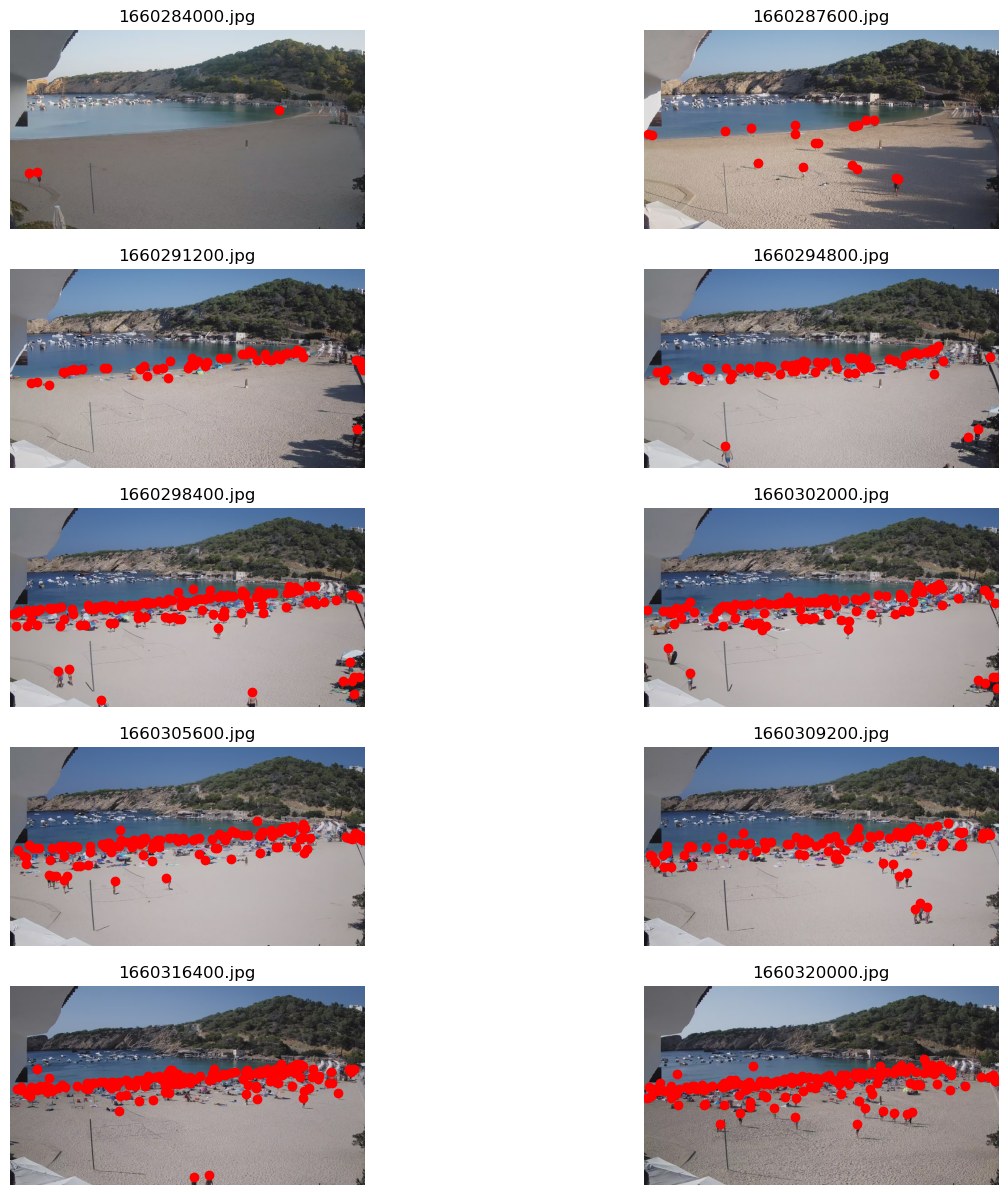

In [6]:
fig, axes = plt.subplots(5, 2, figsize=(15, 15)) 
for ax, img, name in zip(axes.flatten(), input_images, image_names):
    ax.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    ax.set_title(name)
         # Add manual annotations
    for (x, y) in data_manual_points[name]['coordinates']:
        ax.plot(x, y, 'ro')  # red
    ax.axis('off')
plt.show()

In [4]:
annotations.columns

Index(['label', 'point_x', 'point_y', 'image_name', 'image_width',
       'image_height'],
      dtype='object')

In [23]:
annotations['image_id'] = ['image_' + str(i) for i in pd.factorize(annotations['image_name'])[0]]
annotations.head()

label  point_x  point_y      image_name  image_width  image_height  \
0  Person      104      774  1660284000.jpg         1920          1080   
1  Person      148      768  1660284000.jpg         1920          1080   
2  Person     1458      433  1660284000.jpg         1920          1080   
3  Person       18      564  1660287600.jpg         1920          1080   
4  Person       43      568  1660287600.jpg         1920          1080   

  image_id  
0  image_0  
1  image_0  
2  image_0  
3  image_1  
4  image_1

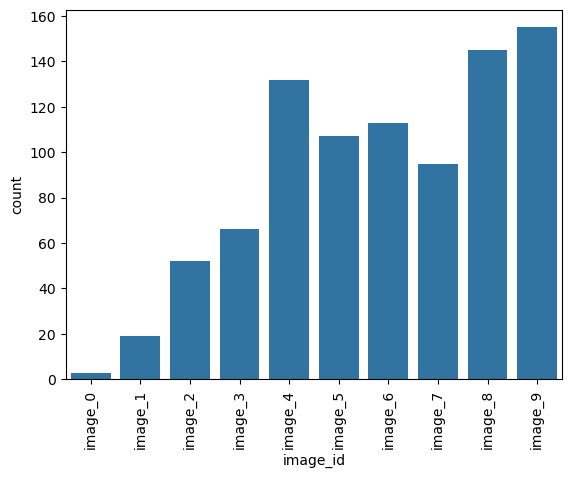

In [6]:
sns.countplot(data=annotations, x = 'image_id')
plt.xticks(rotation=90)
plt.show()

And add other useful data visualization and analysis for the images

### Measure performance
---
To check the algorithm performance using different metrics

In [7]:
class PerformanceGauge:
    metrics = []

    @classmethod
    def add_metric(cls, func_name,time, cpu_used, memory_usage,approx_peak):
        cls.metrics.append({
            'function': func_name,
            'time_took': time,
            'cpu_cycles': cpu_used,
            'memory_usage': memory_usage,
            'memory_peak': approx_peak,
        })

    @classmethod
    def get_metrics(cls):
        return cls.metrics

def measure_performance(func):
    @wraps(func)
    def wrapper(*args, **kwargs):
        process = psutil.Process()
        
        # Initial measures
        cpu_before = psutil.cpu_times()
        tracemalloc.start()
        start_memory = process.memory_info().rss / 1048576  # En MB
        start_time = time.perf_counter()

        result = func(*args, **kwargs)

        # Final metrics
        end_time = time.perf_counter()
        cpu_after = psutil.cpu_times()
        end_memory = process.memory_info().rss / 1048576  # En MB
        current, peak = tracemalloc.get_traced_memory()
        tracemalloc.stop()
        
        cpu_used = cpu_after.user - cpu_before.user
        memory_usage = end_memory - start_memory
        duration = end_time - start_time
        approx_peak=peak / 10**6
        # Save metrics
        PerformanceGauge.add_metric(func.__name__, duration,cpu_used, memory_usage,approx_peak )
        return result
    return wrapper

## Algorithm

Also try to get the colour differences for images that have umbrellas. Umbrellas have colours red, pink, green etc.

In [8]:
from src.methods import get_canny_edges, rgb_distance_mask

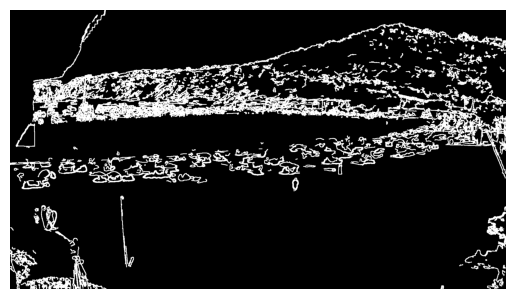

In [9]:
bel1 = get_canny_edges(input_images[5], input_images[0])

plt.imshow(bel1, cmap='gray')
plt.axis('off')
plt.show()

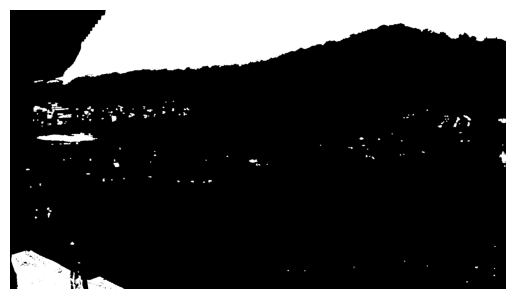

In [10]:
bel2 = rgb_distance_mask(input_images[5], input_images[0], thresh=80, morph=True)

plt.imshow(bel2, cmap='gray')
plt.axis('off')
plt.show()

In [11]:
mask = cv2.bitwise_or(bel1, bel2)
mask = cv2.erode(mask, np.ones((3,3)))

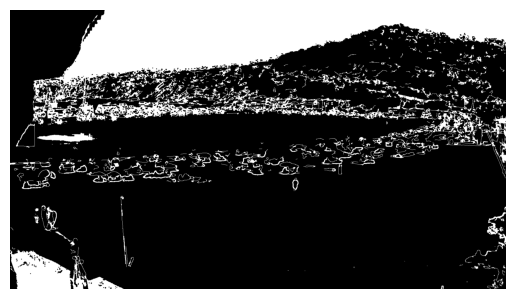

In [12]:
plt.imshow(mask, cmap='gray')
plt.axis('off')
plt.show()

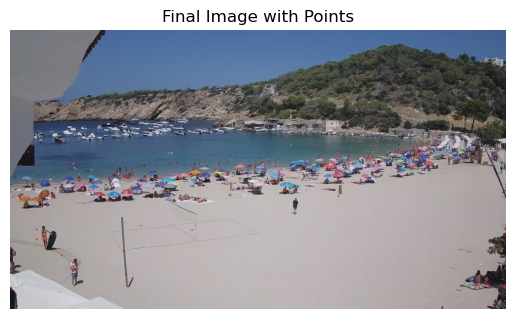

In [13]:
num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(mask, connectivity=8)
    
points = []
for i in range(1, num_labels): # Skip background label 0
    area = stats[i][cv2.CC_STAT_AREA]
    centroid = centroids[i]
        
        # Filter points based on area and y position
    if (50 < area < 1000 and 
        centroid[1] > 450):
        points.append((int(centroid[0]), int(centroid[1])))
    
    
vis_img = input_images[5].copy()
for p in points:
    cv2.circle(vis_img, p, 3, (0,0,255), -1)
plt.imshow(cv2.cvtColor(vis_img, cv2.COLOR_BGR2RGB))
plt.title('Final Image with Points')
plt.axis('off')
plt.show()

### All Images

In [15]:
@measure_performance
def count_crowd(target_img, base_img):
    tmp_points = []
    # Algoritmo de conteo de multitudes
    bel1 = get_canny_edges(target_img, base_img)
    bel2 = rgb_distance_mask(target_img, base_img, thresh=30, morph=True)
    mask = cv2.bitwise_or(bel1, bel2)
    mask = cv2.erode(mask, np.ones((5,3)))
    num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(mask, connectivity=8)
    for i in range(1, num_labels):
        area = stats[i][cv2.CC_STAT_AREA]
        centroid = centroids[i]
        
        if (50 < area < 1000 and centroid[1] > 450):
            tmp_points.append({'point_x': int(centroid[0]), 'point_y': int(centroid[1]), 'image_id': f'image_{idx}'})
    
    return tmp_points

In [16]:
all_points = []

for idx, img in enumerate(input_images[1:], start=1):
    all_points.extend(count_crowd(img,input_images[0]))
# Create a dataframe from the points
predictions_df = pd.DataFrame(all_points)

In [24]:
annotations_df = annotations[['image_id', 'point_x', 'point_y']]

###  Performance metrics
---


In [17]:
all_metrics = PerformanceGauge.get_metrics()
for metric in all_metrics:
    print(f"Function: {metric['function']}")
    print(f"  Time : {metric['time_took']:.6f} seconds")
    print(f"  CPU cycles: {metric['cpu_cycles']:.6f}")
    print(f"  Memory usage: {metric['memory_usage']:.2f} MB")
    print(f"  Memory peak: {metric['memory_peak']:.2f} MB")
    print("---")

Function: count_crowd
  Time : 0.099495 seconds
  CPU cycles: 0.125000
  Memory usage: -0.90 MB
  Memory peak: 16.74 MB
---
Function: count_crowd
  Time : 0.094211 seconds
  CPU cycles: 0.062500
  Memory usage: -0.36 MB
  Memory peak: 16.59 MB
---
Function: count_crowd
  Time : 0.094459 seconds
  CPU cycles: 0.125000
  Memory usage: 1.94 MB
  Memory peak: 16.59 MB
---
Function: count_crowd
  Time : 0.088699 seconds
  CPU cycles: 0.093750
  Memory usage: 0.56 MB
  Memory peak: 16.59 MB
---
Function: count_crowd
  Time : 0.084940 seconds
  CPU cycles: 0.093750
  Memory usage: 2.25 MB
  Memory peak: 16.59 MB
---
Function: count_crowd
  Time : 0.081659 seconds
  CPU cycles: 0.046875
  Memory usage: -2.11 MB
  Memory peak: 16.59 MB
---
Function: count_crowd
  Time : 0.083812 seconds
  CPU cycles: 0.046875
  Memory usage: 0.24 MB
  Memory peak: 16.59 MB
---
Function: count_crowd
  Time : 0.097867 seconds
  CPU cycles: 0.078125
  Memory usage: -1.98 MB
  Memory peak: 16.59 MB
---
Function: co

### Image Level Evaluation

In [18]:
eval_df = pd.DataFrame(predictions_df['image_id'].value_counts().to_list(), columns = ['image_id'])

In [25]:
eval_df = eval_df.join(pd.DataFrame(annotations_df['image_id'].value_counts().to_list(), columns = ['image_id']), rsuffix='_gt')
eval_df = eval_df.rename(columns={'image_id': 'people', 'image_id_gt': 'people_gt'})
eval_df = eval_df.sort_index()

In [26]:
eval_df['mse'] = np.power(eval_df['people'] - eval_df['people_gt'], 2)
eval_df['error_percentage'] = np.abs(100 - np.divide(eval_df['people'], eval_df['people_gt']) * 100)

In [27]:
eval_df

people  people_gt    mse  error_percentage
0     423        155  71824        172.903226
1     178        145   1089         22.758621
2     164        132   1024         24.242424
3     101        113    144         10.619469
4      27        107   6400         74.766355
5      26         95   4761         72.631579
6      25         66   1681         62.121212
7      21         52    961         59.615385
8      20         19      1          5.263158

In [28]:
print(f"Mean MSE: {eval_df['mse'].mean()}")

Mean MSE: 9765.0


### Person Level Evaluation

In [29]:
def is_within_radius(p1, p2, radius):
    return np.sqrt((p1[0] - p2[0])**2 + (p1[1] - p2[1])**2) <= radius

tp = {}
fn = {}
fp = {}
iou = {}
gt_v_pred = [input_images[0]]
fp_flag = 0
radius = 30  

for x, img in enumerate(annotations_df['image_id'].unique()):
    if x == 0:
        continue
    out = input_images[x].copy()
    df = annotations_df[annotations_df['image_id'] == img]
    img_points = [p for p in all_points if p['image_id'] == img]
    
    for p in img_points:
        for _, b in df.iterrows():
            fp_flag = 0
            
            if is_within_radius((b['point_x'], b['point_y']), (p['point_x'], p['point_y']), radius):
                if img not in tp:
                    tp[img] = 0
                tp[img] += 1
                cv2.circle(out, (b['point_x'], b['point_y']), radius, (127, 255, 25), 3)
                cv2.circle(out, (p['point_x'], p['point_y']), 5, (0, 0, 255), -1)
                fp_flag = 1
                break

        if fp_flag == 0:
            if img not in fp:
                fp[img] = 0
            fp[img] += 1

    gt_v_pred.append(out)

    fn[img] = df.shape[0] - tp.get(img, 0)

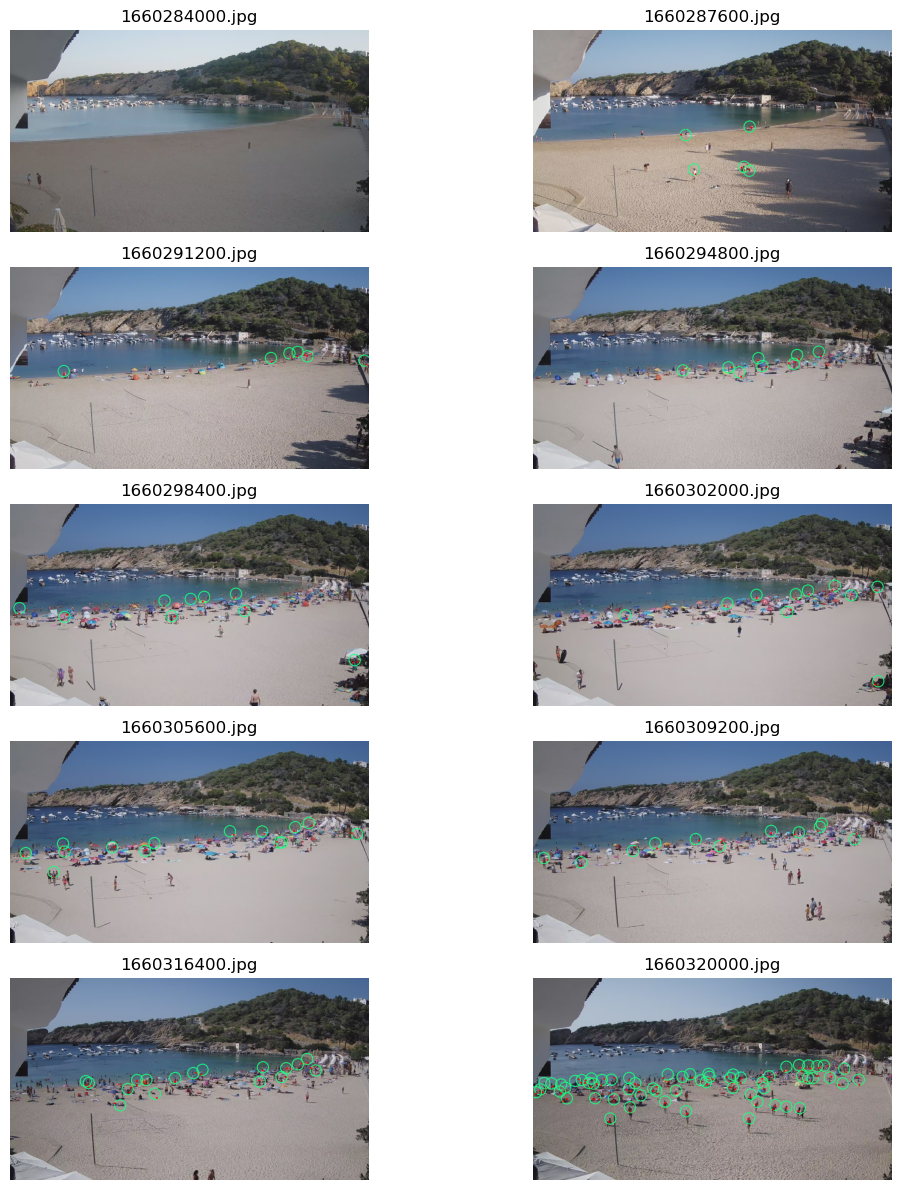

In [30]:
fig, axes = plt.subplots(5, 2, figsize=(12, 12))
for ax, img, name in zip(axes.flatten(), gt_v_pred, image_names):
    ax.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    ax.set_title(name)
    ax.axis('off')
plt.tight_layout()
plt.show()

In [31]:
# Blank

In [32]:
acc_score = pd.DataFrame([tp, fp, fn]).T
acc_score = acc_score.rename(columns={0: 'tp', 1: 'fp', 2: 'fn'})
acc_score['precision'] = acc_score['tp'] / (acc_score['tp'] + acc_score['fp'])
acc_score['recall'] = acc_score['tp'] / (acc_score['tp'] + acc_score['fn'])
acc_score['f1'] = 2 * (acc_score['precision'] * acc_score['recall']) / (acc_score['precision'] + acc_score['recall'])
acc_score['accuracy'] = acc_score['tp'] / (acc_score['tp'] + acc_score['fp'] + acc_score['fn'])

In [33]:
acc_score

tp   fp   fn  precision    recall        f1  accuracy
image_1   6  158   13   0.036585  0.315789  0.065574  0.033898
image_2   8   93   44   0.079208  0.153846  0.104575  0.055172
image_3  10   11   56   0.476190  0.151515  0.229885  0.129870
image_4  10   16  122   0.384615  0.075758  0.126582  0.067568
image_5  10   15   97   0.400000  0.093458  0.151515  0.081967
image_6  15   12   98   0.555556  0.132743  0.214286  0.120000
image_7  11    9   84   0.550000  0.115789  0.191304  0.105769
image_8  22  156  123   0.123596  0.151724  0.136223  0.073090
image_9  83  340   72   0.196217  0.535484  0.287197  0.167677

In [34]:
print(f"Average precision: {acc_score['precision'].mean() * 100:.2f}%")
print(f"Average recall: {acc_score['recall'].mean() * 100:.2f}%")
print(f"Average accuracy: {acc_score['accuracy'].mean() * 100:.2f}%")
print(f"Average F1 score: {acc_score['f1'].mean() * 100:.2f}%")
print(f"Total true-positives: {acc_score['tp'].sum()}")

Average precision: 31.13%
Average recall: 19.18%
Average accuracy: 9.28%
Average F1 score: 16.75%
Total true-positives: 175


### Comparison with Deep Learning Methods

In [28]:
from ultralytics import YOLO

In [30]:
model = YOLO('yolov8m.pt')  

classes = [0]

100%|██████████| 49.7M/49.7M [00:03<00:00, 13.5MB/s]


In [52]:
yolo_preds = []

fig, axs = plt.subplots(5, 2, figsize=(15, 30))
for idx, (ax, img) in enumerate(zip(axs.flatten(), input_images[1:]), start=1):
    img_yolo = img.copy()
    img_yolo = cv2.cvtColor(img_yolo, cv2.COLOR_BGR2RGB)
    results = model(img_yolo, classes=classes)
    annotated_img = results[0].plot() 
    yolo_preds.append(results[0].boxes.xywh.shape[0])
    
    ax.imshow(cv2.cvtColor(annotated_img, cv2.COLOR_BGR2RGB))
    ax.axis('off')

plt.tight_layout()
plt.show()

/var/folders/6s/29zyjkhd39s4nfqnksw42_200000gn/T/ipykernel_1950/87345306.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, axs = plt.subplots(5, 2, figsize=(15, 30))


0: 384x640 12 persons, 206.5ms
Speed: 4.4ms preprocess, 206.5ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 6 persons, 209.2ms
Speed: 1.4ms preprocess, 209.2ms inference, 0.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 persons, 139.0ms
Speed: 2.1ms preprocess, 139.0ms inference, 0.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 12 persons, 140.5ms
Speed: 1.4ms preprocess, 140.5ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 persons, 146.6ms
Speed: 1.8ms preprocess, 146.6ms inference, 0.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 7 persons, 136.6ms
Speed: 1.6ms preprocess, 136.6ms inference, 0.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 9 persons, 157.6ms
Speed: 1.4ms preprocess, 157.6ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 11 persons, 164.1ms
Speed: 1.9ms preprocess, 164.1ms inference, 0.7ms postprocess pe

In [53]:
eval_df['yolo'] = yolo_preds
eval_df['yolo_mse'] = np.power(eval_df['yolo'] - eval_df['people_gt'], 2)

In [54]:
eval_df

people  people_gt   mse  error_percentage  yolo  yolo_mse
0     118        155  1369         23.870968    12     20449
1     115        145   900         20.689655     6     19321
2     110        132   484         16.666667     5     16129
3     107        113    36          5.309735    12     10201
4     105        107     4          1.869159     5     10404
5     103         95    64          8.421053     7      7744
6      75         66    81         13.636364     9      3249
7      42         52   100         19.230769    11      1681
8      31         19   144         63.157895    12        49

In [55]:
print(f"Mean MSE: {eval_df['yolo_mse'].mean()}")

Mean MSE: 9914.111111111111
